# Hydrauliikkadatan tarkistus ja puhdistus

Tämä notebook sisältää kaksi pääosiota:
1. Datan tarkistus - etsitään puuttuvat arvot ja poikkeavat havainnot
2. Datan puhdistus - poistetaan virheelliset rivit

## Tarvittavat kirjastot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Remove the maximum column limit
pd.set_option('display.max_columns', None)
# Remove the maximum row limit
pd.set_option('display.max_rows', None)
# Set the display width to fit your screen
pd.set_option('display.width', None)
# Remove the maximum string length limit
sys.set_int_max_str_digits(0)  # Poista numeroiden tulostusrajoitus

## 1. Datan tarkistus

### 1.1 Datan lataus ja perustarkistukset

In [2]:
# Määritä tiedostopolut
input_file = '../Data/corruptedHydraulicData.csv'

# Lue data
print(f"Luetaan data tiedostosta: {input_file}")
df = pd.read_csv(input_file)
print(f"Data luettu onnistuneesti. Rivejä: {len(df)}\n")

# Tarkista sarakkeet ja datatyypit
print("Sarakkeet ja datatyypit:")
print(df.dtypes)
print("\n")

Luetaan data tiedostosta: ../Data/corruptedHydraulicData.csv
Data luettu onnistuneesti. Rivejä: 10000

Sarakkeet ja datatyypit:
pumpControl    float64
pressure       float64
state           object
dtype: object




### 1.2 Puuttuvien arvojen analyysi

Missing values-analyysi:


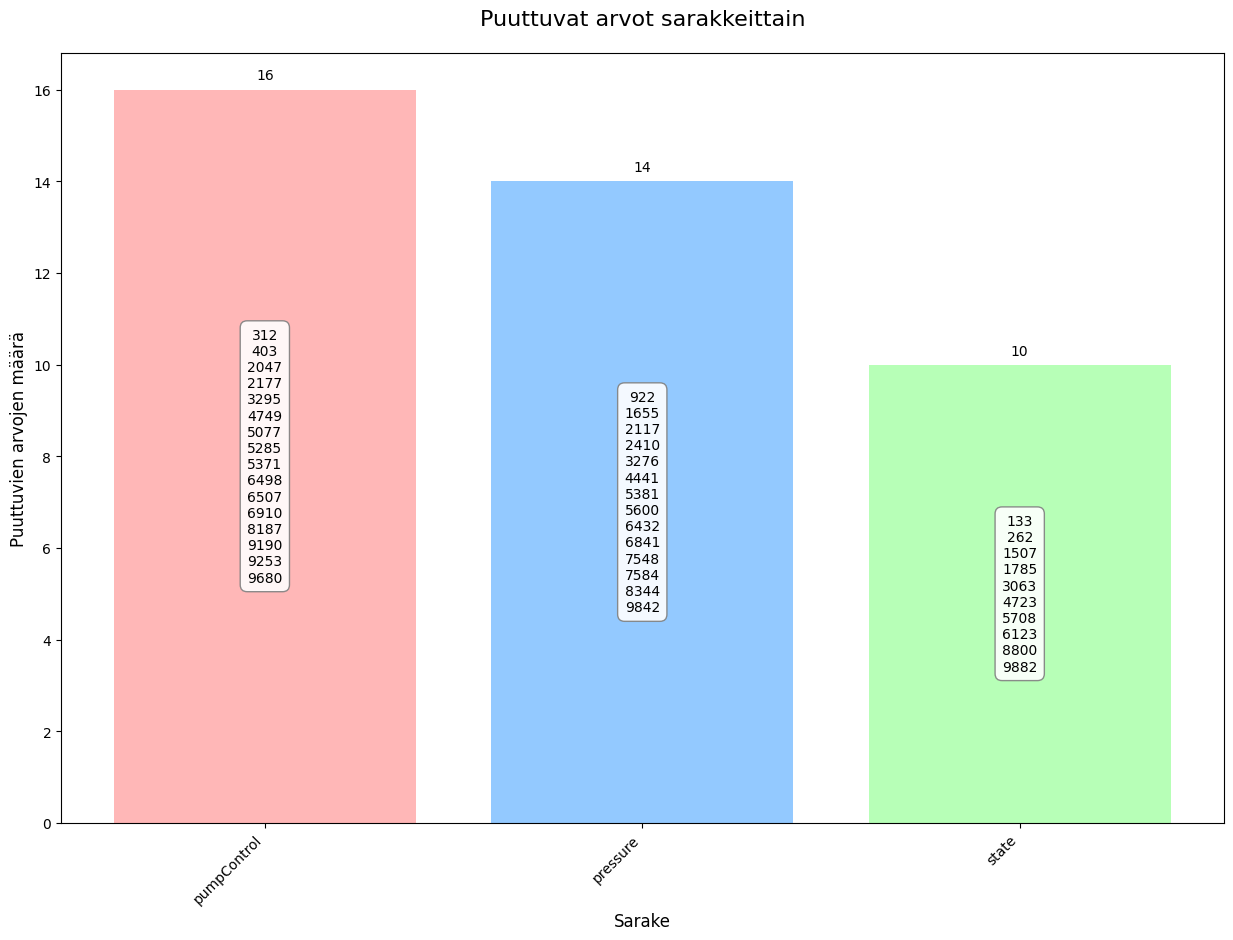

In [3]:
# Tarkista puuttuvat arvot
print("Missing values-analyysi:")

# Lisää apufunktio
def addValueLabel(ax, spacing=5):
    """Lisää arvot pylväisiin"""
    for rect in ax.patches:
        yValue = rect.get_height()
        xValue = rect.get_x() + rect.get_width()/2
        label = f"{int(yValue)}"
        ax.annotate(label, (xValue, yValue), xytext=(0, spacing),
                   textcoords="offset points", ha='center', va='bottom')

# Puuttuvien arvojen visualisointi
plt.figure(figsize=(15, 10))
missingCounts = df.isnull().sum()

# Luo pylväsdiagrammi
plt.bar(range(len(missingCounts)), missingCounts, color=['#FF9999', '#66B2FF', '#99FF99'], alpha=0.7)

# Lisää sarakkeiden nimet ja indeksit
plt.xticks(range(len(missingCounts)), missingCounts.index, rotation=45, ha='right')

# Lisää puuttuvien arvojen indeksit pylväisiin
for idx, (column, count) in enumerate(missingCounts.items()):
    if count > 0:
        missingIndices = df[df[column].isnull()].index.tolist()
        missingIndices.sort()
        indicesText = "\n".join(map(str, missingIndices))
        bbox_props = dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.9)
        plt.text(idx, count/2, indicesText, ha='center', va='center',
                fontsize=10, color='black', bbox=bbox_props)

plt.title('Puuttuvat arvot sarakkeittain', fontsize=16, pad=20)
plt.xlabel('Sarake', fontsize=12)
plt.ylabel('Puuttuvien arvojen määrä', fontsize=12)

# Lisää arvot pylväisiin
current_ax = plt.gca()  # Hae nykyinen axes-objekti
addValueLabel(current_ax)

# Tallennetaan puuttuvien arvojen kuvaaja
plt.savefig('../Visualization/missingValuesAnalysis.png', bbox_inches='tight', dpi=300)
plt.show()

### 1.3 Poikkeavien havaintojen analyysi

Outlier-analyysi:


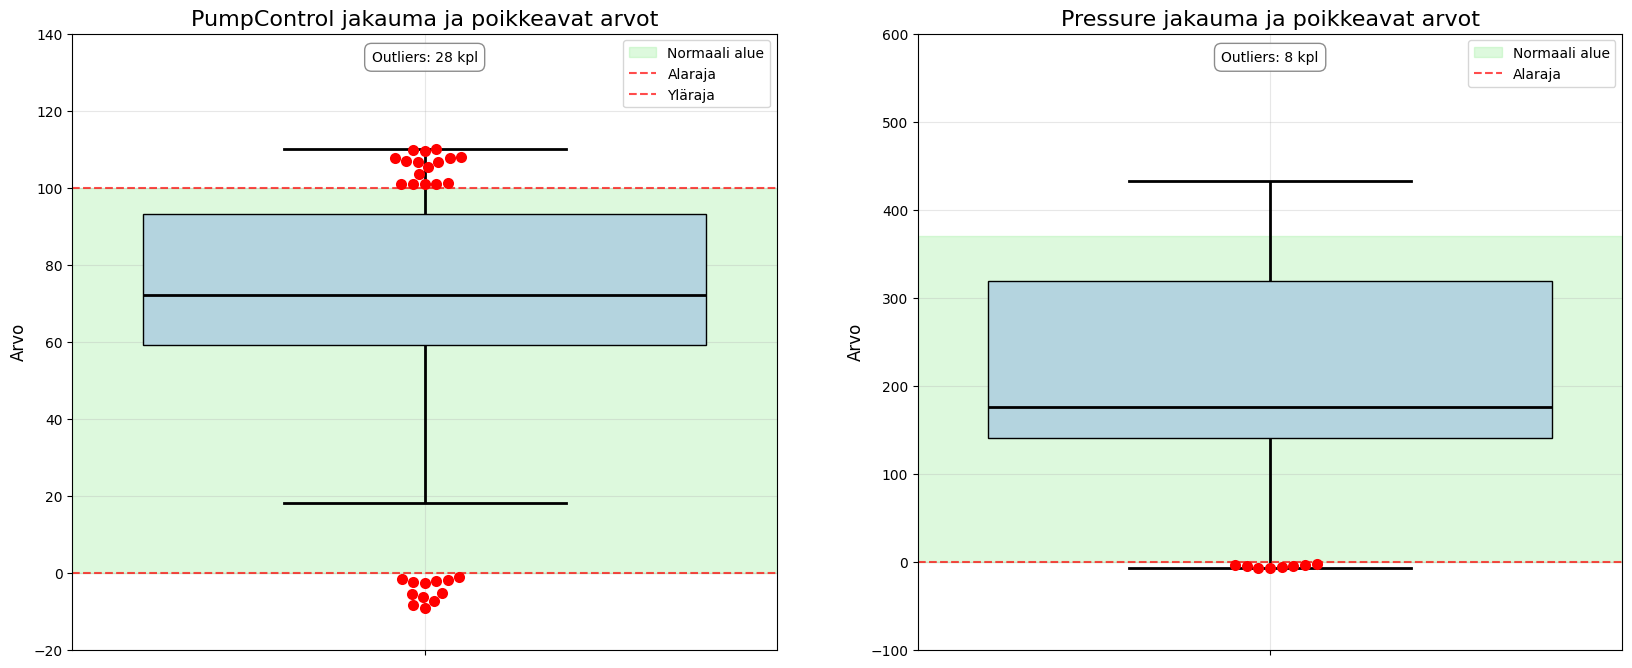

In [4]:
# Tarkista outlierit
print("Outlier-analyysi:")

# Luodaan kuva outliereille
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# PumpControl outlierit
ymin, ymax = -20, 140
ax1.set_ylim(ymin, ymax)

# Määritä normaali alue
pump_normal = {'min': 0, 'max': 100}

# Boxplot ja swarmplot
sns.boxplot(data=df['pumpControl'], ax=ax1, color='lightblue',
           medianprops=dict(color="black", linewidth=2),
           boxprops=dict(edgecolor="black"),
           whiskerprops=dict(color="black", linewidth=2),
           capprops=dict(color="black", linewidth=2),
           flierprops=dict(marker='None'))

outlier_mask = (df['pumpControl'] < 0) | (df['pumpControl'] > 100)
outlier_data = df[outlier_mask]['pumpControl']
sns.swarmplot(data=outlier_data, ax=ax1, color='red', size=8)

# Normaali alue ja rajat
ax1.axhspan(pump_normal['min'], pump_normal['max'],
           color='lightgreen', alpha=0.3, label='Normaali alue')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Alaraja')
ax1.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Yläraja')

# Outlier-määrä
pumpOutliers = len(outlier_data)
bbox_props = dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.9)
text_y = ymax - (ymax - ymin) * 0.05
ax1.text(0, text_y, f'Outliers: {pumpOutliers} kpl', 
        ha='center', va='bottom', bbox=bbox_props)

ax1.set_title('PumpControl jakauma ja poikkeavat arvot', fontsize=16)
ax1.set_ylabel('Arvo', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# Pressure outlierit
ymin, ymax = -100, 600
ax2.set_ylim(ymin, ymax)

pressure_normal = {'min': 0, 'max': df['pressure'].quantile(0.99)}

sns.boxplot(data=df['pressure'], ax=ax2, color='lightblue',
           medianprops=dict(color="black", linewidth=2),
           boxprops=dict(edgecolor="black"),
           whiskerprops=dict(color="black", linewidth=2),
           capprops=dict(color="black", linewidth=2),
           flierprops=dict(marker='None'))

outlier_mask = (df['pressure'] < 0)
outlier_data = df[outlier_mask]['pressure']
sns.swarmplot(data=outlier_data, ax=ax2, color='red', size=8)

ax2.axhspan(pressure_normal['min'], pressure_normal['max'],
           color='lightgreen', alpha=0.3, label='Normaali alue')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Alaraja')

pressureOutliers = len(outlier_data)
text_y = ymax - (ymax - ymin) * 0.05
ax2.text(0, text_y, f'Outliers: {pressureOutliers} kpl', 
        ha='center', va='bottom', bbox=bbox_props)

ax2.set_title('Pressure jakauma ja poikkeavat arvot', fontsize=16)
ax2.set_ylabel('Arvo', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

# Tallennetaan outlier-kuvaaja
plt.savefig('../Visualization/outliersValuesAnalysis.png', bbox_inches='tight', dpi=300)
plt.show()

## 2. Datan puhdistus

### 2.1 Virheellisten rivien poisto

In [5]:
# Tarkista alkuperäiset ongelmat
print("\nALKUPERÄINEN DATA:")
print("--------------------")
print(f"Rivejä yhteensä: {len(df)}")

# Tarkista puuttuvat arvot per sarake
missing_values = df.isnull().sum()
print("\nPuuttuvat arvot:")
for col in df.columns:
    missing = missing_values[col]
    print(f"- {col}: {missing} kpl")

# Tarkista poikkeavat arvot
pump_outliers = df[(df['pumpControl'] < 0) | (df['pumpControl'] > 100)]
pressure_outliers = df[df['pressure'] < 0]

print(f"\nPumpControl outlierit (<0 tai >100): {len(pump_outliers)} kpl")
print(f"Pressure outlierit (<0): {len(pressure_outliers)} kpl\n")

# Poista rivit joissa puuttuvia arvoja
print("Poistetaan rivit joissa puuttuvia arvoja...")
df_clean = df.dropna()

# Poista outlier-rivit
print("Poistetaan outlier-rivit...")
df_clean = df_clean[
    (df_clean['pumpControl'] >= 0) & 
    (df_clean['pumpControl'] <= 100) &
    (df_clean['pressure'] >= 0)
]

# Tarkista puhdistetun datan tilanne
print("\nPUHDISTETTU DATA:")
print("--------------------")
print(f"Poistettuja rivejä: {len(df) - len(df_clean)}")
print(f"Rivejä jäljellä: {len(df_clean)}")

# Tarkista puuttuvat arvot puhdistetusta datasta
missing_after = df_clean.isnull().sum()
print("\nPuuttuvat arvot:")
for col in df_clean.columns:
    missing = missing_after[col]
    print(f"- {col}: {missing} kpl")

# Tarkista poikkeavat arvot puhdistetusta datasta
pump_outliers_after = len(df_clean[(df_clean['pumpControl'] < 0) | (df_clean['pumpControl'] > 100)])
pressure_outliers_after = len(df_clean[df_clean['pressure'] < 0])

print(f"\nPumpControl outlierit (<0 tai >100): {pump_outliers_after} kpl")
print(f"Pressure outlierit (<0): {pressure_outliers_after} kpl")




ALKUPERÄINEN DATA:
--------------------
Rivejä yhteensä: 10000

Puuttuvat arvot:
- pumpControl: 16 kpl
- pressure: 14 kpl
- state: 10 kpl

PumpControl outlierit (<0 tai >100): 28 kpl
Pressure outlierit (<0): 8 kpl

Poistetaan rivit joissa puuttuvia arvoja...
Poistetaan outlier-rivit...

PUHDISTETTU DATA:
--------------------
Poistettuja rivejä: 76
Rivejä jäljellä: 9924

Puuttuvat arvot:
- pumpControl: 0 kpl
- pressure: 0 kpl
- state: 0 kpl

PumpControl outlierit (<0 tai >100): 0 kpl
Pressure outlierit (<0): 0 kpl


### 2.1 Puhdistetun datan tallennus

In [6]:
# Tallenna puhdistettu data
output_file = '../Data/cleanHydraulicData.csv'
df_clean.to_csv(output_file, index=False)
print(f"\nPuhdistettu data tallennettu tiedostoon: {output_file}")


Puhdistettu data tallennettu tiedostoon: ../Data/cleanHydraulicData.csv
